# Notebook 3, Feature Engineering and Modeling

This notebook creates rolling features, encodes region, prepares a time-aware train/test split per region, and trains three models (Linear Regression, Random Forest, XGBoost) for monthly Rainfall and Temperature prediction.  
We compute RMSE and MAE overall and per region, and plot actual vs predicted for the best model per target.

Notes:
- Rolling windows: 3 and 12 months (per region).
- Lags assumed: lag 1,2,3 and lag 12 for both variables.
- Region column name is `REGION`, year is `YEAR`, month numeric is `Month_Num` or `Month`.
- Default holdout: last 24 months per region.


### Step 1, Load processed dataset 

We try to load `model_ready_dataset.csv`. If it is not present, we load the uploaded file  and convert it from wide to long format like Notebook 1 did. This ensures the notebook is resilient and reproducible.


In [52]:
# Step 1: load or recreate the processed dataset
import os
import pandas as pd
import numpy as np

# Paths (relative) - adjust if your notebook runs from a different working dir
model_ready_path = os.path.join('..','4_data_analysis','model_datasets','model_ready_dataset.csv')
final_merged_path = os.path.join('..','1_datasets','Final_dataset','final_merged_dataset.csv')

def create_monthly_from_annual(df_wide):
    months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    # Melt rainfall
    rain_long = df_wide.melt(id_vars=["REGION","YEAR"],
                            value_vars=[m + "_RAIN" for m in months],
                            var_name="Month_Rain", value_name="Rainfall")
    # Melt temp
    temp_long = df_wide.melt(id_vars=["REGION","YEAR"],
                            value_vars=[m + "_TEMP" for m in months],
                            var_name="Month_Temp", value_name="Temperature")
    rain_long["Month"] = rain_long["Month_Rain"].str.split("_").str[0]
    temp_long["Month"] = temp_long["Month_Temp"].str.split("_").str[0]
    df_long = pd.merge(
        rain_long[["REGION","YEAR","Month","Rainfall"]],
        temp_long[["REGION","YEAR","Month","Temperature"]],
        on=["REGION","YEAR","Month"]
    )
    month_order = {"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
                "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
    df_long["Month_Num"] = df_long["Month"].map(month_order)
    # Create a time index per region
    df_long = df_long.sort_values(["REGION","YEAR","Month_Num"]).reset_index(drop=True)
    df_long["Time"] = df_long.groupby("REGION").cumcount()
    return df_long

# Try to load a pre-prepared model-ready dataset first, otherwise build from the final merged wide file
if os.path.exists(model_ready_path):
    df = pd.read_csv(model_ready_path)
    print(f"Loaded model-ready dataset from {model_ready_path}")
elif os.path.exists(final_merged_path):
    df_wide = pd.read_csv(final_merged_path)
    print(f"Loaded final merged dataset from {final_merged_path}; converting to monthly long format")
    df = create_monthly_from_annual(df_wide)
else:
    raise FileNotFoundError(f"Neither {model_ready_path} nor {final_merged_path} found. Please provide the dataset at one of these paths.")

# Quick check
print(df.columns.tolist())
df.head()


Loaded model-ready dataset from ..\4_data_analysis\model_datasets\model_ready_dataset.csv
['REGION', 'YEAR', 'Month', 'Rainfall', 'Temperature', 'Month_Num', 'Time', 'Rain_lag_1', 'Temp_lag_1', 'Rain_lag_2', 'Temp_lag_2', 'Rain_lag_3', 'Temp_lag_3', 'Rain_lag_12', 'Temp_lag_12']


,REGION,YEAR,Month,Rainfall,Temperature,Month_Num,Time,Rain_lag_1,Temp_lag_1,Rain_lag_2,Temp_lag_2,Rain_lag_3,Temp_lag_3,Rain_lag_12,Temp_lag_12
0,Central,1991,JAN,0.000000,22.685222,1,12,0.000000,27.665444,0.0,29.210333,0.387,32.436444,0.000,23.057667
1,Central,1991,FEB,0.000000,24.895333,2,13,0.000000,22.685222,0.0,27.665444,0.000,29.210333,0.000,22.018000
2,Central,1991,MAR,0.000000,27.808889,3,14,0.000000,24.895333,0.0,22.685222,0.000,27.665444,0.000,25.144778
3,Central,1991,APR,0.047333,33.137556,4,15,0.000000,27.808889,0.0,24.895333,0.000,22.685222,0.000,30.844667
4,Central,1991,MAY,0.216000,35.484000,5,16,0.047333,33.137556,0.0,27.808889,0.000,24.895333,0.002,33.960222


### Step 2, Create rolling features and verify lag columns

We compute 3-month and 12-month rolling means for Rainfall and Temperature, grouped by REGION and ordered by time.  
We also detect existing lag columns from notebook 1. If lag columns are missing, we create the standard lags 1,2,3,12 here.


In [53]:
# Step 2: rolling features + ensure lags exist
df = df.copy()

# Ensure Month_Num exists: if the file uses Month instead of Month_Num convert
if "Month_Num" not in df.columns:
    if "Month" in df.columns and df["Month"].dtype == object:
        month_map = {"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
                    "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
        df["Month_Num"] = df["Month"].map(month_map)
    elif "Month" in df.columns:
        df["Month_Num"] = df["Month"]
    else:
        raise KeyError("No Month or Month_Num column found. Please ensure Notebook 1 created Month_Num.")

# Ensure Time column exists
if "Time" not in df.columns:
    df = df.sort_values(["REGION","YEAR","Month_Num"]).reset_index(drop=True)
    df["Time"] = df.groupby("REGION").cumcount()

# Create rolling means per region
df = df.sort_values(["REGION","Year" if "Year" in df.columns else "YEAR","Month_Num"], ignore_index=True)
# Some datasets use YEAR uppercase, normalize
if "Year" in df.columns and "YEAR" not in df.columns:
    df.rename(columns={"Year":"YEAR"}, inplace=True)

df = df.sort_values(["REGION","YEAR","Month_Num"]).reset_index(drop=True)

# Rolling windows (compute using past values only to avoid leakage)
for var in ["Rainfall","Temperature"]:
    # shift by 1 so the rolling mean uses only previous months (no data leakage)
    df[f"{var}_roll3"] = df.groupby("REGION")[var].transform(lambda x: x.shift(1).rolling(window=3, min_periods=3).mean())
    df[f"{var}_roll12"] = df.groupby("REGION")[var].transform(lambda x: x.shift(1).rolling(window=12, min_periods=12).mean())

# Detect lag columns, create if not present
def ensure_lags(df, var, lags=[1,2,3,12]):
    created = []
    for lag in lags:
        cname = f"{var}_lag_{lag}"
        if cname not in df.columns:
            df[cname] = df.groupby("REGION")[var].shift(lag)
            created.append(cname)
    return created

created_rain_lags = ensure_lags(df, "Rainfall", [1,2,3,12])
created_temp_lags = ensure_lags(df, "Temperature", [1,2,3,12])

print("Created lag columns:", created_rain_lags + created_temp_lags)

# Drop rows that have any NaN in the required features (lags or rolls)
required_cols = []
required_cols += [f"Rainfall_lag_{i}" if False else f"Rainfall_lag_{i}" for i in [1,2,3,12]]  # names consistent
# fix names because we created f"{var}_lag_{lag}" above, with var exact
required_cols = [f"Rainfall_lag_{i}" for i in [1,2,3,12]] + [f"Temperature_lag_{i}" for i in [1,2,3,12]] + \
                ["Rainfall_roll3","Rainfall_roll12","Temperature_roll3","Temperature_roll12"]

# But actual created names are Rainfall_lag_1 etc. Confirm existence:
required_cols = [c for c in required_cols if c in df.columns]

# Add cyclical month features for seasonality (good for linear models)
df['Month_sin'] = np.sin(2 * np.pi * (df['Month_Num'] / 12))
df['Month_cos'] = np.cos(2 * np.pi * (df['Month_Num'] / 12))
print("Required columns available for modeling (sample):", required_cols[:10])


Created lag columns: ['Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'Temperature_lag_12']
Required columns available for modeling (sample): ['Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'Temperature_lag_12', 'Rainfall_roll3', 'Rainfall_roll12']


In [54]:
# Drop rows missing any of these
df_model = df.dropna(subset=required_cols).reset_index(drop=True)
print("After dropping rows with missing lag/rolling features, shape:", df_model.shape)

# Show sample
df_model.head()

After dropping rows with missing lag/rolling features, shape: (1980, 29)


,REGION,YEAR,Month,Rainfall,Temperature,Month_Num,Time,Rain_lag_1,Temp_lag_1,Rain_lag_2,...,Rainfall_lag_1,Rainfall_lag_2,Rainfall_lag_3,Rainfall_lag_12,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Temperature_lag_12,Month_sin,Month_cos
0,Central,1992,JAN,0.000000,21.373889,1,24,0.000,22.874889,0.002333,...,0.000,0.002333,0.167333,0.000000,22.874889,27.483222,32.269778,22.685222,0.500000,8.660254e-01
1,Central,1992,FEB,0.000000,21.334222,2,25,0.000,21.373889,0.000000,...,0.000,0.000000,0.002333,0.000000,21.373889,22.874889,27.483222,24.895333,0.866025,5.000000e-01
2,Central,1992,MAR,0.000000,27.497889,3,26,0.000,21.334222,0.000000,...,0.000,0.000000,0.000000,0.000000,21.334222,21.373889,22.874889,27.808889,1.000000,6.123234e-17
3,Central,1992,APR,0.003000,30.957444,4,27,0.000,27.497889,0.000000,...,0.000,0.000000,0.000000,0.047333,27.497889,21.334222,21.373889,33.137556,0.866025,-5.000000e-01
4,Central,1992,MAY,0.292333,32.862667,5,28,0.003,30.957444,0.000000,...,0.003,0.000000,0.000000,0.216000,30.957444,27.497889,21.334222,35.484000,0.500000,-8.660254e-01


### Step 3, Encode REGION and prepare feature lists

We create a `REGION_CODE` numeric column using LabelEncoder (for tree models), and we will use OneHotEncoder inside the linear regression pipeline.  
We then build the list of numeric features and the final features that will be used for each model.


In [55]:
# Step 3: encode REGION, prepare feature lists
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge

df_model = df_model.copy()
le = LabelEncoder()
df_model["REGION_CODE"] = le.fit_transform(df_model["REGION"].astype(str))

# Feature candidate lists
# numeric base features
numeric_base = ["YEAR","Time"]  # ensure these exist
numeric_base = [c for c in ["YEAR", "Time", "Month_sin", "Month_cos"] if c in df_model.columns]

# lag features
rain_lags = [c for c in df_model.columns if c.startswith("Rainfall_lag_")]
temp_lags = [c for c in df_model.columns if c.startswith("Temperature_lag_")]
rolls = [c for c in df_model.columns if c.endswith("_roll3") or c.endswith("_roll12")]

# Combine features
features_for_trees = ["REGION_CODE"] + numeric_base + rain_lags + temp_lags + rolls
# For linear model we'll use the same numeric set but one-hot REGION inside pipeline
features_for_linear = numeric_base + rain_lags + temp_lags + rolls  # REGION will be one-hot encoded inside pipeline

# Show counts
print("Features for tree models (sample):", features_for_trees[:10])
print("Features for linear model (sample):", features_for_linear[:10])
print("Number of rows available:", len(df_model))

df_model.head()


Features for tree models (sample): ['REGION_CODE', 'YEAR', 'Time', 'Month_sin', 'Month_cos', 'Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1']
Features for linear model (sample): ['YEAR', 'Time', 'Month_sin', 'Month_cos', 'Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2']
Number of rows available: 1980


,REGION,YEAR,Month,Rainfall,Temperature,Month_Num,Time,Rain_lag_1,Temp_lag_1,Rain_lag_2,...,Rainfall_lag_2,Rainfall_lag_3,Rainfall_lag_12,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Temperature_lag_12,Month_sin,Month_cos,REGION_CODE
0,Central,1992,JAN,0.000000,21.373889,1,24,0.000,22.874889,0.002333,...,0.002333,0.167333,0.000000,22.874889,27.483222,32.269778,22.685222,0.500000,8.660254e-01,0
1,Central,1992,FEB,0.000000,21.334222,2,25,0.000,21.373889,0.000000,...,0.000000,0.002333,0.000000,21.373889,22.874889,27.483222,24.895333,0.866025,5.000000e-01,0
2,Central,1992,MAR,0.000000,27.497889,3,26,0.000,21.334222,0.000000,...,0.000000,0.000000,0.000000,21.334222,21.373889,22.874889,27.808889,1.000000,6.123234e-17,0
3,Central,1992,APR,0.003000,30.957444,4,27,0.000,27.497889,0.000000,...,0.000000,0.000000,0.047333,27.497889,21.334222,21.373889,33.137556,0.866025,-5.000000e-01,0
4,Central,1992,MAY,0.292333,32.862667,5,28,0.003,30.957444,0.000000,...,0.000000,0.000000,0.216000,30.957444,27.497889,21.334222,35.484000,0.500000,-8.660254e-01,0


### Step 4, Train/test split per region (time-aware)

We hold out the last `test_periods` months per region for testing, concatenating all regions' train and test sets into global training and test sets.  
Default `test_periods` is 24 months, changeable below.


In [56]:
# Step 4: train-test split per region
test_periods = 24  # months held out per region, change if you want a shorter/longer holdout

def train_test_time_split(df, group_col="REGION", time_col="Time", test_periods=24):
    train_parts = []
    test_parts = []
    for name, g in df.groupby(group_col):
        g_sorted = g.sort_values(time_col).reset_index(drop=True)
        if len(g_sorted) <= test_periods:
            raise ValueError(f"Region {name} has <= {test_periods} rows, reduce test_periods")
        train_parts.append(g_sorted.iloc[:-test_periods].copy())
        test_parts.append(g_sorted.iloc[-test_periods:].copy())
    return pd.concat(train_parts).reset_index(drop=True), pd.concat(test_parts).reset_index(drop=True)

train_df, test_df = train_test_time_split(df_model, group_col="REGION", time_col="Time", test_periods=test_periods)
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


Train shape: (1860, 30) Test shape: (120, 30)


### Step 5, Define evaluation helpers

We will use R2, RMSE and MAE. We also create functions to evaluate overall and per-region performance for a given true and predicted array.


In [57]:
# Step 5: evaluation helpers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def evaluate_overall(true, pred):
    return {"rmse": rmse(true, pred), "mae": mae(true, pred), "r2": r2(true, pred)}

def evaluate_per_region(df_true, df_pred, group_col="REGION"):
    merged = pd.merge(df_true, df_pred, on=["REGION","YEAR","Month_Num"])
    rows = []
    for region, g in merged.groupby(group_col):
        rows.append({
            "REGION": region,
            "r2": r2(g["target_true"], g["target_pred"]),
            "mae": mae(g["target_true"], g["target_pred"]),
            "rmse": rmse(g["target_true"], g["target_pred"])
        })
    # sort by R2 descending so higher R2 (better) appear first
    return pd.DataFrame(rows).sort_values("r2", ascending=False)

### Step 6, Modeling function for one target

This cell defines a function that trains Linear Regression, Random Forest and XGBoost for a specified target.  
It returns predictions for the test set, the model objects, and a small summary table of overall metrics.


In [58]:
# Step 6: modeling function
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def train_and_evaluate(target, features_linear, features_trees, train_df=train_df, test_df=test_df):
    # Prepare data
    X_train_lin = train_df[features_linear].copy()
    X_test_lin = test_df[features_linear].copy()
    X_train_tree = train_df[features_trees].copy()
    X_test_tree = test_df[features_trees].copy()
    y_train = train_df[target].copy()
    y_test = test_df[target].copy()

    # Linear pipeline: OneHot for REGION + scaler for numerical
    # Identify categorical and numeric for ColumnTransformer
    cat_cols = ["REGION"] if "REGION" in train_df.columns else []
    num_cols = [c for c in features_linear if c not in cat_cols]

    # Build transformer list safely (avoid empty tuples). Use dense output from OneHotEncoder
    transformers = []
    if len(cat_cols) and "REGION" in features_linear:
        # Build OneHotEncoder in a version-compatible way (sparse vs sparse_output)
        try:
            ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
        except TypeError:
            # Newer scikit-learn versions use `sparse_output` instead of `sparse`
            ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        transformers.append(("ohe_region", ohe, ["REGION"]))
    if len(num_cols):
        transformers.append(("scale", StandardScaler(), num_cols))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    # Ensure REGION column is present in the data passed to the linear pipeline if we plan to OHE it
    if "REGION" in train_df.columns and "REGION" not in X_train_lin.columns:
        X_train_lin = train_df[features_linear + ["REGION"]].copy()
        X_test_lin = test_df[features_linear + ["REGION"]].copy()

    lr_pipeline = Pipeline(steps=[("pre", preprocessor), ("lr", Ridge(alpha=1.0))])
    lr_pipeline.fit(X_train_lin, y_train)
    lr_pred = lr_pipeline.predict(X_test_lin)

    # Random Forest (trees pipeline) - use features_trees which include REGION_CODE
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train_tree, y_train)
    rf_pred = rf.predict(X_test_tree)

    # XGBoost
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbosity=0)
    xgb.fit(X_train_tree, y_train)
    xgb_pred = xgb.predict(X_test_tree)

    # Evaluate overall
    lr_metrics = evaluate_overall(y_train, lr_pipeline.predict(X_train_lin)) if False else evaluate_overall(y_test, lr_pred)
    rf_metrics = evaluate_overall(y_test, rf_pred)
    xgb_metrics = evaluate_overall(y_test, xgb_pred)

    summary = pd.DataFrame({
        "Model": ["Ridge","RandomForest","XGBoost"],
        "R2": [lr_metrics["r2"], rf_metrics["r2"], xgb_metrics["r2"]],
        "MAE": [lr_metrics["mae"], rf_metrics["mae"], xgb_metrics["mae"]],
        "RMSE": [lr_metrics["rmse"], rf_metrics["rmse"], xgb_metrics["rmse"]]
    }).sort_values("R2", ascending=False)

    # Prepare prediction dataframes for per-region evaluation
    # include REGION, YEAR, Month_Num for merging
    base_test_info = test_df[["REGION","YEAR","Month_Num"]].reset_index(drop=True)
    lr_pred_df = base_test_info.copy()
    lr_pred_df["target_pred"] = lr_pred
    rf_pred_df = base_test_info.copy()
    rf_pred_df["target_pred"] = rf_pred
    xgb_pred_df = base_test_info.copy()
    xgb_pred_df["target_pred"] = xgb_pred

    # True frame
    true_df = base_test_info.copy()
    true_df["target_true"] = y_test.values

    try:
        rf_importances = pd.Series(rf.feature_importances_, index=X_train_tree.columns).sort_values(ascending=False)
    except Exception:
        rf_importances = None
    try:
        xgb_importances = pd.Series(xgb.feature_importances_, index=X_train_tree.columns).sort_values(ascending=False)
    except Exception:
        xgb_importances = None
    models = {"linear": lr_pipeline, "rf": rf, "xgb": xgb, "rf_importance": rf_importances, "xgb_importance": xgb_importances}
    preds = {"linear": lr_pred_df, "rf": rf_pred_df, "xgb": xgb_pred_df}

    return summary, true_df, preds, models

### Step 7, Train and evaluate models for Rainfall

We run the modeling function for the Rainfall target and show the summary table plus per-region performance.  
The best model is selected by overall RMSE.


In [59]:
# Step 7: rain modeling
rain_summary, rain_true_df, rain_preds, rain_models = train_and_evaluate(
    target="Rainfall",
    features_linear=["REGION"] + features_for_linear,  # include REGION for one-hot encoder
    features_trees=features_for_trees
)

print("Rainfall model summary (sorted by R2):")
display(rain_summary)

# Per-region evaluation
rain_lr_reg = evaluate_per_region(rain_true_df.rename(columns={"target_true":"target_true"}), rain_preds["linear"].rename(columns={"target_pred":"target_pred"}))
rain_rf_reg = evaluate_per_region(rain_true_df.rename(columns={"target_true":"target_true"}), rain_preds["rf"].rename(columns={"target_pred":"target_pred"}))
rain_xgb_reg = evaluate_per_region(rain_true_df.rename(columns={"target_true":"target_true"}), rain_preds["xgb"].rename(columns={"target_pred":"target_pred"}))

print("Per-region, Linear Regression (Rain):")
display(rain_lr_reg)
print("Per-region, Random Forest (Rain):")
display(rain_rf_reg)
print("Per-region, XGBoost (Rain):")
display(rain_xgb_reg)


Rainfall model summary (sorted by R2):


,Model,R2,MAE,RMSE
2,XGBoost,0.866743,0.435963,0.817374
1,RandomForest,0.856804,0.468571,0.847309
0,Ridge,0.840021,0.531433,0.895587


Per-region, Linear Regression (Rain):


,REGION,r2,mae,rmse
4,West,0.874670,0.535871,0.943483
3,South,0.865591,0.820719,1.125067
0,Central,0.596381,0.594325,0.972939
1,East,0.379958,0.486727,0.893542
2,North,0.175889,0.219524,0.330778


Per-region, Random Forest (Rain):


,REGION,r2,mae,rmse
4,West,0.883881,0.535084,0.908154
3,South,0.861709,0.758601,1.141201
0,Central,0.709536,0.463497,0.825365
2,North,0.616352,0.106916,0.225689
1,East,0.432768,0.478758,0.854643


Per-region, XGBoost (Rain):


,REGION,r2,mae,rmse
4,West,0.914255,0.446997,0.780392
3,South,0.865141,0.799944,1.126949
0,Central,0.663179,0.455481,0.888791
1,East,0.542687,0.366004,0.767381
2,North,0.377447,0.111387,0.287496


### Step 8, Train and evaluate models for Temperature

We repeat the same pipeline for the Temperature target and display results. This allows direct comparison of model families for both variables.


In [60]:
# Step 8: temp modeling
temp_summary, temp_true_df, temp_preds, temp_models = train_and_evaluate(
    target="Temperature",
    features_linear=["REGION"] + features_for_linear,
    features_trees=features_for_trees
)

print("Temperature model summary (sorted by RMSE):")
display(temp_summary)

# Per-region evaluation
temp_lr_reg = evaluate_per_region(temp_true_df.rename(columns={"target_true":"target_true"}), temp_preds["linear"].rename(columns={"target_pred":"target_pred"}))
temp_rf_reg = evaluate_per_region(temp_true_df.rename(columns={"target_true":"target_true"}), temp_preds["rf"].rename(columns={"target_pred":"target_pred"}))
temp_xgb_reg = evaluate_per_region(temp_true_df.rename(columns={"target_true":"target_true"}), temp_preds["xgb"].rename(columns={"target_pred":"target_pred"}))

print("Per-region RMSE, Linear Regression (Temp):")
display(temp_lr_reg)
print("Per-region RMSE, Random Forest (Temp):")
display(temp_rf_reg)
print("Per-region RMSE, XGBoost (Temp):")
display(temp_xgb_reg)


Temperature model summary (sorted by RMSE):


,Model,R2,MAE,RMSE
2,XGBoost,0.918653,0.990610,1.224620
1,RandomForest,0.915984,0.981035,1.244549
0,Ridge,0.915720,1.001631,1.246497


Per-region RMSE, Linear Regression (Temp):


,REGION,r2,mae,rmse
2,North,0.950445,1.178283,1.433974
1,East,0.909111,0.928786,1.117691
0,Central,0.884897,1.007406,1.289643
4,West,0.861092,1.052670,1.339024
3,South,0.849683,0.841012,1.003544


Per-region RMSE, Random Forest (Temp):


,REGION,r2,mae,rmse
2,North,0.938395,1.343610,1.598852
0,Central,0.913431,0.812548,1.118431
1,East,0.911952,0.908622,1.100084
3,South,0.893078,0.743779,0.846380
4,West,0.844221,1.096614,1.418011


Per-region RMSE, XGBoost (Temp):


,REGION,r2,mae,rmse
2,North,0.949138,1.174295,1.452764
0,Central,0.904054,0.902886,1.177444
3,South,0.899527,0.719832,0.820458
1,East,0.887021,1.045542,1.246137
4,West,0.862442,1.110495,1.332501


### Step 10, **Diagnostics & Interpretation**

This section shows diagnostic plots and variable importance for the *best* model per target (selected by highest R2 on the test set). It contains:
- A histogram of residuals (Actual - Predicted) to check bias, skewness and heavy tails.
- Top feature importances for tree models (RF/XGBoost) when applicable.
- Overall test metrics (RMSE, MAE, R2) printed for quick reference.
- The figures are saved to `../4_data_analysis/Figures/model_diagnostics/` with filenames that include the target and model name (for example `residuals_rain_Ridge.png` or `rf_importance_temp_XGBoost.png`).



Rainfall best model: XGBoost
Overall metrics (test): {'rmse': 0.8173740297959189, 'mae': 0.43596253018520537, 'r2': 0.8667430647411171}


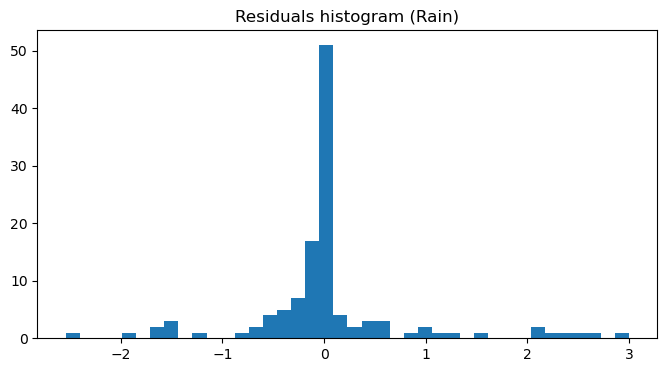

Saved residuals plot to ..\4_data_analysis\Figures\model_diagnostics\residuals_rain_XGBoost.png
Top XGB features (Rain):


Rainfall_lag_12       0.405119
Month_cos             0.116913
Rainfall_roll3        0.103991
Rainfall_lag_1        0.098925
Rainfall_roll12       0.049049
Temperature_lag_1     0.024912
Month_sin             0.024317
Temperature_lag_3     0.024102
Temperature_lag_2     0.021462
Temperature_roll12    0.020522
dtype: float32

Saved XGB importance plot to ..\4_data_analysis\Figures\model_diagnostics\xgb_importance_rain_XGBoost.png
Temperature best model: XGBoost
Overall metrics (test): {'rmse': 1.2246196282061013, 'mae': 0.9906101461683003, 'r2': 0.9186528014711548}


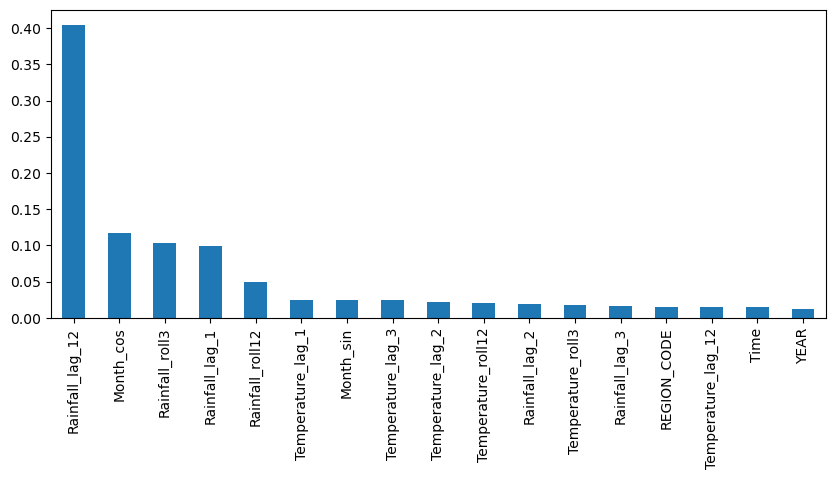

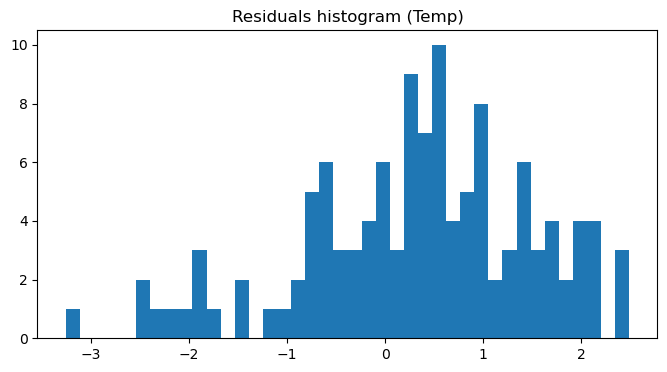

Saved residuals plot to ..\4_data_analysis\Figures\model_diagnostics\residuals_temp_XGBoost.png
Top XGB features (Temp):


Temperature_lag_12    0.518665
Month_cos             0.222989
Temperature_lag_1     0.068610
Rainfall_roll12       0.033756
Rainfall_roll3        0.025618
Rainfall_lag_1        0.025430
Month_sin             0.016514
Rainfall_lag_3        0.011743
Temperature_lag_3     0.011355
Temperature_roll3     0.010821
dtype: float32

Saved XGB importance plot to ..\4_data_analysis\Figures\model_diagnostics\xgb_importance_temp_XGBoost.png


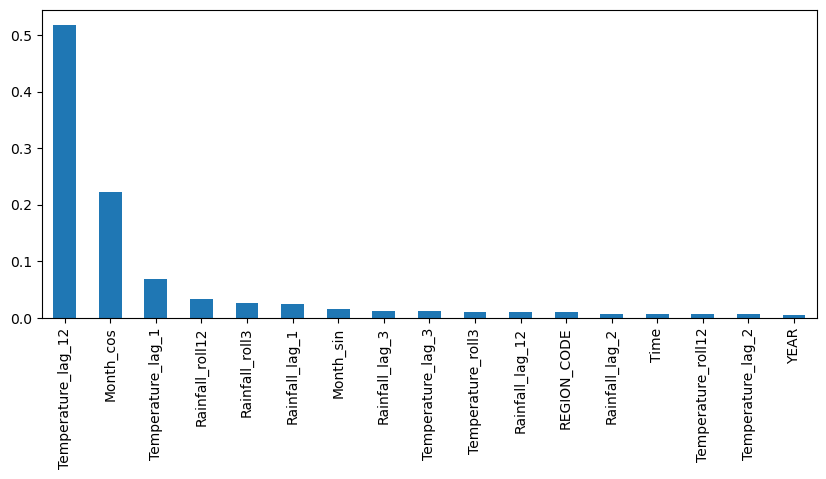

In [62]:
# Diagnostics: feature importances and residuals for best models
import matplotlib.pyplot as plt
import os

# Directory to save figures (relative to repo root)
figures_dir = os.path.join('..','4_data_analysis','Figures','model_diagnostics')
os.makedirs(figures_dir, exist_ok=True)

# Use R2 as the model comparison metric; mapping keys reflect model names in the summary
mapping = {'Ridge':'linear','RandomForest':'rf','XGBoost':'xgb'}

# Rainfall best model (choose by highest R2)
best_rain_model_name = rain_summary.sort_values('R2', ascending=False).iloc[0]['Model']
best_rain_key = mapping[best_rain_model_name]
best_rain_model = rain_models[best_rain_key]
best_rain_pred_df = rain_preds[best_rain_key]
best_rain_true_df = rain_true_df.copy()
merged_r = pd.merge(best_rain_true_df, best_rain_pred_df, on=['REGION','YEAR','Month_Num'])
resid = merged_r['target_true'] - merged_r['target_pred']
print('Rainfall best model:', best_rain_model_name)
print('Overall metrics (test):', evaluate_overall(merged_r['target_true'], merged_r['target_pred']))

# Residuals histogram (Rain) - show and save
plt.figure(figsize=(8,4))
plt.hist(resid, bins=40)
plt.title('Residuals histogram (Rain)')
resid_path = os.path.join(figures_dir, f"residuals_rain_{best_rain_model_name}.png")
plt.savefig(resid_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"Saved residuals plot to {resid_path}")

# Feature importances (Rain) - plot & save when available
if best_rain_key=='rf' and rain_models.get('rf_importance') is not None:
    print('Top RF features (Rain):')
    display(rain_models['rf_importance'].head(10))
    ax = rain_models['rf_importance'].head(20).plot.bar(figsize=(10,4))
    imp_path = os.path.join(figures_dir, f"rf_importance_rain_{best_rain_model_name}.png")
    ax.get_figure().savefig(imp_path, bbox_inches='tight', dpi=150)
    print(f"Saved RF importance plot to {imp_path}")
elif best_rain_key=='xgb' and rain_models.get('xgb_importance') is not None:
    print('Top XGB features (Rain):')
    display(rain_models['xgb_importance'].head(10))
    ax = rain_models['xgb_importance'].head(20).plot.bar(figsize=(10,4))
    imp_path = os.path.join(figures_dir, f"xgb_importance_rain_{best_rain_model_name}.png")
    ax.get_figure().savefig(imp_path, bbox_inches='tight', dpi=150)
    print(f"Saved XGB importance plot to {imp_path}")

# Temperature best model (choose by highest R2)
best_temp_model_name = temp_summary.sort_values('R2', ascending=False).iloc[0]['Model']
best_temp_key = mapping[best_temp_model_name]
best_temp_model = temp_models[best_temp_key]
best_temp_pred_df = temp_preds[best_temp_key]
best_temp_true_df = temp_true_df.copy()
merged_t = pd.merge(best_temp_true_df, best_temp_pred_df, on=['REGION','YEAR','Month_Num'])
resid_t = merged_t['target_true'] - merged_t['target_pred']
print('Temperature best model:', best_temp_model_name)
print('Overall metrics (test):', evaluate_overall(merged_t['target_true'], merged_t['target_pred']))

# Residuals histogram (Temp) - show and save
plt.figure(figsize=(8,4))
plt.hist(resid_t, bins=40)
plt.title('Residuals histogram (Temp)')
resid_t_path = os.path.join(figures_dir, f"residuals_temp_{best_temp_model_name}.png")
plt.savefig(resid_t_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"Saved residuals plot to {resid_t_path}")

# Feature importances (Temp) - plot & save when available
if best_temp_key=='rf' and temp_models.get('rf_importance') is not None:
    print('Top RF features (Temp):')
    display(temp_models['rf_importance'].head(10))
    ax = temp_models['rf_importance'].head(20).plot.bar(figsize=(10,4))
    imp_path = os.path.join(figures_dir, f"rf_importance_temp_{best_temp_model_name}.png")
    ax.get_figure().savefig(imp_path, bbox_inches='tight', dpi=150)
    print(f"Saved RF importance plot to {imp_path}")
elif best_temp_key=='xgb' and temp_models.get('xgb_importance') is not None:
    print('Top XGB features (Temp):')
    display(temp_models['xgb_importance'].head(10))
    ax = temp_models['xgb_importance'].head(20).plot.bar(figsize=(10,4))
    imp_path = os.path.join(figures_dir, f"xgb_importance_temp_{best_temp_model_name}.png")
    ax.get_figure().savefig(imp_path, bbox_inches='tight', dpi=150)
    print(f"Saved XGB importance plot to {imp_path}")

**Notebook Summary**

- **R2 added**: The R2 metric (test set) was added to `evaluate_overall` and `evaluate_per_region`, and is used for model selection.
- **Leakage fixed**: Rolling features (`_roll3`, `_roll12`) are computed using past values only via `.shift(1).rolling(...)` to prevent target leakage.
- **Seasonality features**: `Month_sin` and `Month_cos` added to capture cyclic monthly patterns (used by linear model).
- **Linear model updated**: Replaced `LinearRegression` with `Ridge` (regularized) inside the pipeline.
- **Tree models configured**: Random Forest and XGBoost set to use all CPUs (`n_jobs=-1`); feature importances are captured for interpretation.
- **Diagnostics & artifacts**: Residual histograms and feature-importance bar charts are generated and saved to `../4_data_analysis/Figures/model_diagnostics/` when you run the diagnostics cell.

Next steps:
- Re-run the notebook cells in order: Step 2 (feature engineering) → Step 6 (modeling) → Step 7/8 (train per target) → diagnostics cell. This will produce updated metrics and save the diagnostic PNGs.
- Optionally add time-aware cross-validation and hyperparameter tuning (recommended before final model selection).

Files changed: `4_data_analysis/2_model_training_&_comparison.ipynb` — feature engineering, evaluation helpers, modeling function, and diagnostics were updated.